In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1

In [2]:
import os
import shutil
import random

# Dataset: Caltech-101: https://data.caltech.edu/records/mzrjq-6wc02

# Path to the extracted 101_ObjectCategories folder
SOURCE_DIR = '/content/drive/MyDrive/CSCI_6967/HW5/101_ObjectCategories'

# Path to where you want the split dataset
TARGET_DIR = '/content/drive/MyDrive/CSCI_6967/HW5/datasplits'

# Train/Validation/Test ratio
SPLIT_RATIO = (0.7, 0.2, 0.1)  # 70% train, 20% val, 10% test

random.seed(42)

# Create the split directories
splits = ["train", "val", "test"]
for split in splits:
    split_path = os.path.join(TARGET_DIR, split)
    if not os.path.exists(split_path):
        os.makedirs(split_path)

# Split each category
categories = [cat for cat in os.listdir(SOURCE_DIR)
             if os.path.isdir(os.path.join(SOURCE_DIR, cat))]

for cat in categories:
    cat_dir = os.path.join(SOURCE_DIR, cat)
    images = [f for f in os.listdir(cat_dir)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not images:
        # Skip folders that don't contain images
        continue

    # Shuffle images
    random.shuffle(images)

    # Determine split indices
    train_end = int(len(images) * SPLIT_RATIO[0])
    val_end = int(len(images) * (SPLIT_RATIO[0] + SPLIT_RATIO[1]))

    train_images = images[:train_end]
    val_images   = images[train_end:val_end]
    test_images  = images[val_end:]

    # Create subfolders for each category in train/val/test
    for split in splits:
        split_cat_dir = os.path.join(TARGET_DIR, split, cat)
        os.makedirs(split_cat_dir, exist_ok=True)

    # Copy images to train
    for img in train_images:
        src = os.path.join(cat_dir, img)
        dst = os.path.join(TARGET_DIR, "train", cat, img)
        shutil.copy2(src, dst)

    # Copy images to val
    for img in val_images:
        src = os.path.join(cat_dir, img)
        dst = os.path.join(TARGET_DIR, "val", cat, img)
        shutil.copy2(src, dst)

    # Copy images to test
    for img in test_images:
        src = os.path.join(cat_dir, img)
        dst = os.path.join(TARGET_DIR, "test", cat, img)
        shutil.copy2(src, dst)


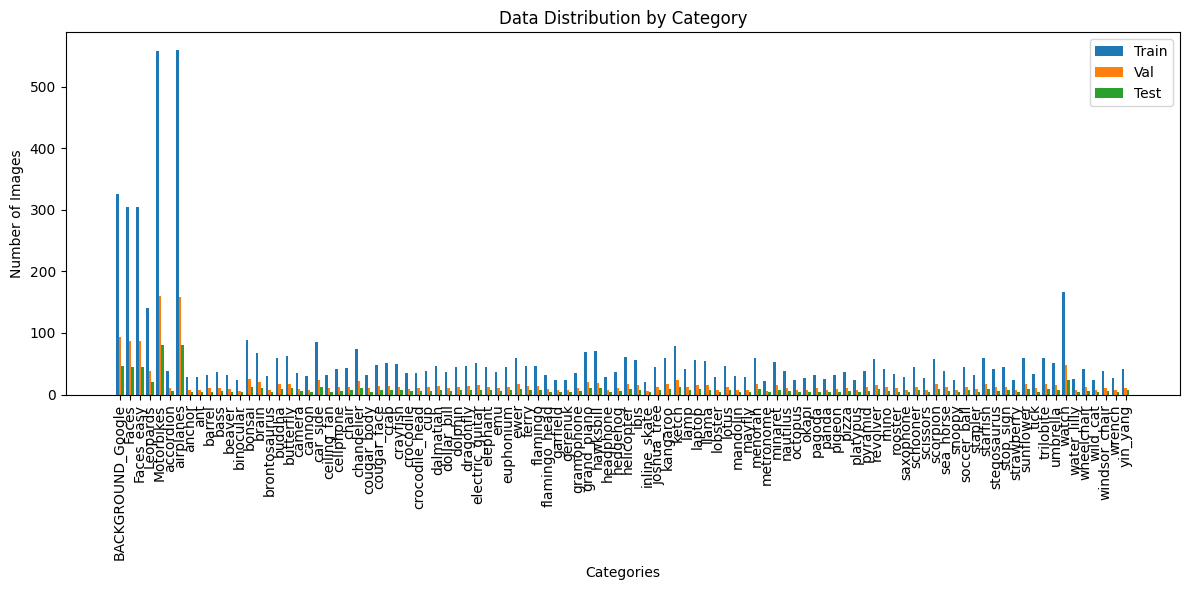

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_data_distribution_by_category(base_dir):
    """
    Plots the distribution of images per category across
    train, val, and test splits in a grouped bar chart.

    :param base_dir: Path to the main directory containing
                     'train', 'val', and 'test' subdirectories.
    """
    splits = ['train', 'val', 'test']

    # 1. Gather category names (assuming the same categories exist in each split)
    #    We'll look at the train folder as a reference for category names
    train_dir = os.path.join(base_dir, 'train')
    categories = [
        d for d in os.listdir(train_dir)
        if os.path.isdir(os.path.join(train_dir, d))
    ]
    categories.sort()  # Sort alphabetically for consistent plotting

    # 2. For each category, count the number of images in train, val, and test
    train_counts = []
    val_counts = []
    test_counts = []

    for cat in categories:
        # Count how many files in each split subfolder
        # that have an image extension
        cat_train_dir = os.path.join(base_dir, 'train', cat)
        cat_val_dir   = os.path.join(base_dir, 'val', cat)
        cat_test_dir  = os.path.join(base_dir, 'test', cat)

        train_images = [
            f for f in os.listdir(cat_train_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        val_images = [
            f for f in os.listdir(cat_val_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        test_images = [
            f for f in os.listdir(cat_test_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        train_counts.append(len(train_images))
        val_counts.append(len(val_images))
        test_counts.append(len(test_images))

    # 3. Create a grouped bar chart
    x = np.arange(len(categories))  # the label locations
    width = 0.25  # width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(x - width, train_counts, width, label='Train', color='tab:blue')
    ax.bar(x,        val_counts,   width, label='Val',   color='tab:orange')
    ax.bar(x + width, test_counts, width, label='Test',  color='tab:green')

    ax.set_xlabel('Categories')
    ax.set_ylabel('Number of Images')
    ax.set_title('Data Distribution by Category')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=90)  # rotate for visibility
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
base_dir = '/content/drive/MyDrive/CSCI_6967/HW5/datasplits'
plot_data_distribution_by_category(base_dir)


In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set device and parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up directory paths and parameters
train_dir = '/content/drive/MyDrive/CSCI_6967/HW5/datasplits/train'
val_dir   = '/content/drive/MyDrive/CSCI_6967/HW5/datasplits/val'
test_dir  = '/content/drive/MyDrive/CSCI_6967/HW5/datasplits/test'

img_height, img_width = 224, 224
batch_size = 32
num_classes = 102  # Adjust if you want to exclude/add any category
epochs = 10

# Apply transforms to convert PIL images to tensors
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),  # Convert PIL Image to Tensor
    ])
)
val_dataset = datasets.ImageFolder(
    root=val_dir,
    transform=transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),  # Convert PIL Image to Tensor
    ])
)
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),  # Convert PIL Image to Tensor
    ])
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the CNN Model

'''
This specific pattern of convolutional layers followed by pooling layers was chosen because it effectively balances feature extraction and computational efficiency.
The use of small 3×3 convolutional filters allows the network to capture detailed local spatial patterns while stacking multiple layers helps in learning increasingly abstract features.
The subsequent 2×2 max pooling layers progressively reduce the spatial dimensions of the feature maps,
which not only decreases the number of parameters and computational load but also introduces a degree of translational invariance, helping to mitigate overfitting.
Additionally, gradually increasing the number of filters from 32 to 64 to 128 allows the model to handle the complexity of a diverse dataset like Caltech-101 by learning more sophisticated representations at each level.
'''

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Block 1: Conv + MaxPool
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),  # Input: 3 channels, Output: 32 channels
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Block 2: Conv + MaxPool
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Block 3: Conv + MaxPool
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # After three conv+pool layers, if we start with 224×224 input:
        #   Block 1: (224-3+1)=222 -> pooling: 111
        #   Block 2: (111-3+1)=109 -> pooling: 54
        #   Block 3: (54-3+1)=52 -> pooling: 26
        # So the flattened size is: 128 * 26 * 26 = 128 * 676 = 86528
        self.fc1 = nn.Linear(128 * 26 * 26, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN(num_classes=num_classes).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss expects raw logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation Loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation Phase
    model.eval()
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    epoch_loss_val = running_loss_val / total_val
    epoch_acc_val = correct_val / total_val
    val_losses.append(epoch_loss_val)
    val_accuracies.append(epoch_acc_val)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} "
          f"Val Loss: {epoch_loss_val:.4f} Val Acc: {epoch_acc_val:.4f}")

# Evaluate on the Test Set
model.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss_test += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

test_loss = running_loss_test / total_test
test_accuracy = correct_test / total_test

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=86528, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=102, bias=True)
)
Epoch [1/10] Train Loss: 3.8492 Train Acc: 0.1982 Val Loss: 3.2008 Val Acc: 0.3180
Epoch [2/10] Train Loss: 3.0643 Train Acc: 0.3397 Val Loss: 2.6973 Val Acc: 0.4247
Epoch [3/10] Train Loss: 2.5898 Train Acc: 0.4169 Val Loss: 2.3565 Val Acc: 0.4795
Epoch [4/10] Trai

Overall, the loss values decreasing and accuracy values increasing across training and validation indicate that the model is learning effectively. A final test accuracy of ~53% for a 102-class problem is significantly above random chance (which would be <1% for 102 classes), though there is still room for further optimization and improvement.

# Part 2

In [3]:
from torchvision import models

# Load MobileNetV2 with pretrained ImageNet weights
model = models.mobilenet_v2(pretrained=True)

# Freeze the feature extractor layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace the final classifier layer
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Move model to the selected device
model = model.to(device)

print(model)

criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s] 

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [4]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 5.1 Main training loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")



Epoch [1/10] Train Loss: 2.0778 Train Acc: 0.5730 | Val Loss: 0.8587 Val Acc: 0.8024
Epoch [2/10] Train Loss: 0.7902 Train Acc: 0.8275 | Val Loss: 0.5914 Val Acc: 0.8566
Epoch [3/10] Train Loss: 0.5759 Train Acc: 0.8681 | Val Loss: 0.5278 Val Acc: 0.8522
Epoch [4/10] Train Loss: 0.4615 Train Acc: 0.8819 | Val Loss: 0.4977 Val Acc: 0.8648
Epoch [5/10] Train Loss: 0.4009 Train Acc: 0.8964 | Val Loss: 0.4724 Val Acc: 0.8654
Epoch [6/10] Train Loss: 0.3535 Train Acc: 0.9090 | Val Loss: 0.4682 Val Acc: 0.8593
Epoch [7/10] Train Loss: 0.3259 Train Acc: 0.9112 | Val Loss: 0.4468 Val Acc: 0.8626
Epoch [8/10] Train Loss: 0.2996 Train Acc: 0.9188 | Val Loss: 0.4765 Val Acc: 0.8610
Epoch [9/10] Train Loss: 0.2799 Train Acc: 0.9246 | Val Loss: 0.4357 Val Acc: 0.8752
Epoch [10/10] Train Loss: 0.2621 Train Acc: 0.9249 | Val Loss: 0.4753 Val Acc: 0.8664


In [5]:
model.eval()
test_running_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss = test_running_loss / test_total
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4538
Test Accuracy: 0.8798


1. Test Loss: CNN: ~2.43, MobileNetV2: ~0.45
2. Test Accuracy: CNN: ~53%, MobileNetV2: ~88%

Yes, there are clear differences between the CNN model in part 1 and MobileNetV2. MovbileNetV2's lower loss and higher accuracy demonstrate the advantage of transfer learning. The main reason for the performance difference is that MobileNetV2 is pretrained on a massive dataset (ImageNet), so it has already learned to extract a wide range of robust features (e.g., edges, textures, shapes) that transfer well to new tasks. In contrast, a CNN trained from scratch must learn all of these features solely from the available training data, which can lead to slower convergence and lower accuracy if the dataset is not large enough. Consequently, the pretrained MobileNetV2 generally achieves better generalization and higher accuracy in fewer epochs than a scratch-trained CNN.

# Part 3

In [8]:
# For training data: random affine transformations (rotation, translation, shear, and scale)
train_transforms = transforms.Compose([
    transforms.RandomAffine(
        degrees=20,
        translate=(0.2, 0.2),
        shear=0.2,
        scale=(0.8, 1.2)
    ),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor()  # Automatically scales image to [0,1]
])

# For validation and test data: only resizing and conversion to tensor
val_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor()
])

# Create datasets and loaders
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=val_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the CNN Model

'''
This specific pattern of convolutional layers followed by pooling layers was chosen because it effectively balances feature extraction and computational efficiency.
The use of small 3×3 convolutional filters allows the network to capture detailed local spatial patterns while stacking multiple layers helps in learning increasingly abstract features.
The subsequent 2×2 max pooling layers progressively reduce the spatial dimensions of the feature maps,
which not only decreases the number of parameters and computational load but also introduces a degree of translational invariance, helping to mitigate overfitting.
Additionally, gradually increasing the number of filters from 32 to 64 to 128 allows the model to handle the complexity of a diverse dataset like Caltech-101 by learning more sophisticated representations at each level.
'''

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Block 1: Conv + MaxPool
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),  # Input: 3 channels, Output: 32 channels
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Block 2: Conv + MaxPool
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Block 3: Conv + MaxPool
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # After three conv+pool layers, if we start with 224×224 input:
        #   Block 1: (224-3+1)=222 -> pooling: 111
        #   Block 2: (111-3+1)=109 -> pooling: 54
        #   Block 3: (54-3+1)=52 -> pooling: 26
        # So the flattened size is: 128 * 26 * 26 = 128 * 676 = 86528
        self.fc1 = nn.Linear(128 * 26 * 26, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN(num_classes=num_classes).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss expects raw logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation Loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation Phase
    model.eval()
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    epoch_loss_val = running_loss_val / total_val
    epoch_acc_val = correct_val / total_val
    val_losses.append(epoch_loss_val)
    val_accuracies.append(epoch_acc_val)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} "
          f"Val Loss: {epoch_loss_val:.4f} Val Acc: {epoch_acc_val:.4f}")

# Evaluate on the Test Set
model.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss_test += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

test_loss = running_loss_test / total_test
test_accuracy = correct_test / total_test

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=86528, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=102, bias=True)
)
Epoch [1/10] Train Loss: 4.1175 Train Acc: 0.1381 Val Loss: 3.7895 Val Acc: 0.1784
Epoch [2/10] Train Loss: 3.6950 Train Acc: 0.2207 Val Loss: 3.4193 Val Acc: 0.2616
Epoch [3/10] Train Loss: 3.4796 Train Acc: 0.2571 Val Loss: 3.3427 Val Acc: 0.2770
Epoch [4/10] Trai

Data augmentation slightly decreased the test accuracy from around ~53% to ~44%. This can happen for a few reasons: (1) Excessive or poorly tuned augmentations may have distorted the images beyond what the network can learn effectively, reducing accuracy; (2) Not enough training epochs to allow the network to adjust to the augmented data; (3) Model capacity or hyperparameters (e.g., learning rate) may not be optimal for the added variability. Generally, data augmentation helps networks generalize better by simulating a larger and more varied training set, but if the augmentations are too aggressive, the model underfits or struggles to converge, which can lead to lower test performance.